In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import salem

In [2]:
#### IMPORTANTE:
### Configurando caminhos:
path_shapefiles = '/home/andre/Desktop/PCI-INPE/01-relatorio_jan/'

In [3]:
def lat_long_offset(lat, lon, x, y):
    '''
    lat, lon : Provide lat lon coordinates
    x, y : Provide offset of x and y on lat and long respectively
           This needs to be in meters!
           
    The approximation is taken from an aviation formula from this stack exchange 
    https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
    '''
    
    R=6378137

    dLat = x/R
    dLon = y/(R*np.cos(np.pi*lat/180))

    latO = lat + dLat * 180/np.pi
    lonO = lon + dLon * 180/np.pi
    
    return latO, lonO

lat_long_offset_vec = np.vectorize(lat_long_offset)

In [4]:
def get_mesh(lat, lon, dist, coors):
    mini, maxi = -dist*coors, dist*coors
    n_coord = coors*2+1
    axis = np.linspace(mini, maxi, n_coord)
    X, Y = np.meshgrid(axis, axis)
    mesh = lat_long_offset_vec(lat, lon, X, Y)
    mesh_x_y_format = np.stack(mesh).transpose(1,2,0)
    
    return mesh_x_y_format

In [5]:
output = get_mesh(-23.600795, -45.97279, 10000, 25)

def Swap(arr, start_index, last_index): 
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]] 

for i in range(len(output)):
    Swap(output[i], 0, 1)

In [6]:
l0medias = []

p = np.arange(0, 50, 1)
for i in p:
    l0medias.append( (np.mean([output[i][0][0], output[i+1][0][0]]), np.mean([output[0][0][1], output[0][1][1]])) )

In [7]:
############################################################################################
##### Lista com 50 listas para os pontos médios:
lista_listas_linhasx = []
for i in range(len(np.arange(0, 50, 1))):
    lista_listas_linhasx.append([])

############################################################################################
##### Inserindo a localização média de cada caixa (é uma tupla tipo (lon_media, lat_media)):
p = np.arange(0, 50, 1)
for j in range(len(p)):
    for i in range(len(p)):
        lista_listas_linhasx[j].append( (np.mean([output[i][0][0], output[i+1][0][0]]), np.mean([output[0][j][1], output[0][j+1][1]])) )

In [8]:
import pandas as pd
### Dicionario de listas: 
dic = {}
for i in range(len(lista_listas_linhasx)):
    dic.update( {'linha_{0}'.format(i):lista_listas_linhasx[i]} )
df = pd.DataFrame(dic)

### Exportando as localizações centrais das grades em um arquivo pickle:
df.to_pickle('/home/andre/Desktop/PCI-INPE/01-relatorio_jan/localizacoes_medias_elementos_de_grade_FCTH.pickle')

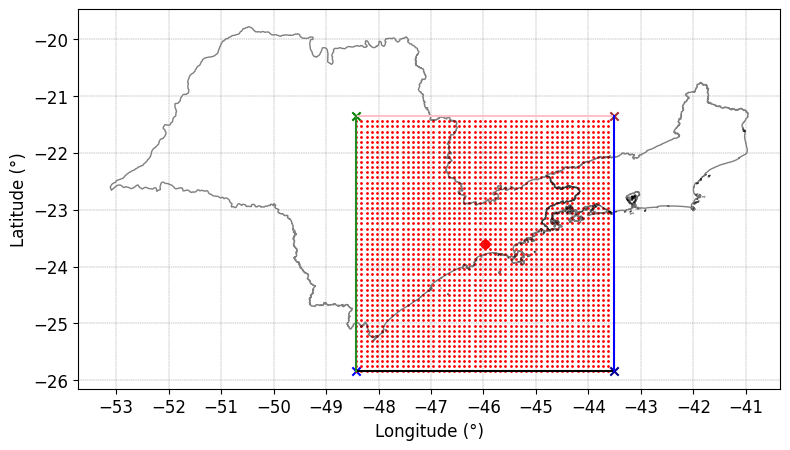

In [9]:
### Plotando todas as grades sobre a região Sudeste:
fig = plt.figure(figsize=(8, 8), facecolor='white') 
ax = fig.add_subplot(1,1,1)
tf = 12

ax.scatter(output[25][25][0], output[25][25][1], color='r')   # centro
ax.scatter(output[0][0][0], output[0][0][1], marker='x', color='blue')
ax.scatter(output[0][0][0], output[0][50][1], marker='x', color='green')
ax.scatter(output[50][0][0], output[0][0][1], marker='x', color='darkblue')
ax.scatter(output[50][50][0], output[50][50][1], marker='x', color='brown')

ax.plot([output[0][0][0], output[50][0][0]], [output[0][0][1], output[0][0][1]], c='k')
ax.plot([output[0][50][0], output[50][50][0]], [output[0][50][1], output[50][50][1]], c='pink')
ax.plot([output[0][0][0], output[0][0][0]], [output[0][0][1], output[0][50][1]], c='forestgreen')
ax.plot([output[50][0][0], output[50][0][0]], [output[50][0][1], output[50][50][1]], c='b')

p = np.arange(0, 50, 1)
for j in p:
    for i in p:
        ax.scatter(output[i][j][0], output[i][j][1], c='red', s=1)

ax.set_xlabel('Longitude (°)', fontsize=tf, color='black')
ax.set_ylabel('Latitude (°)', fontsize=tf, color='black')
ax.grid(visible=True, axis='both', color='gray', linestyle='--', linewidth=0.3, alpha=1)

### Usando shapefiles do IBGE:
## Lendo shapefile de todos Estados do Brasil:
estados_brasil = salem.read_shapefile(path_shapefiles + 'BR_UF_2019.shp')
## Selecionando os Estados que o radar abrange:
estados_desastre = estados_brasil.loc[ (estados_brasil['SIGLA_UF'] == 'SP') | (estados_brasil['SIGLA_UF'] == 'RJ')]
## Desenhando o contorno dos estados:
estados_desastre.plot(edgecolor='black', facecolor='none', linewidth=1, alpha=.5, ax=ax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=tf, color='black')

plt.tight_layout()

### Salvando a figura:
plt.savefig('/home/andre/Desktop/PCI-INPE/01-relatorio_jan/Grades_e_seus_centros_FCTH.png', bbox_inches='tight', dpi=300)